In [ ]:
pip install pandas numpy lightgbm scikit-learn matplotlib

In [ ]:
import pandas as pd

# Load the dataset (update path to your CSV file)
df = pd.read_csv('/content/eurusd_hour.csv')  # Replace with actual path

# Inspect first few rows and columns
print(df.head())
print(df.info())

         Date   Time      BO      BH      BL      BC     BCh      AO      AH  \
0  2005-05-02  00:00  1.2852  1.2852  1.2840  1.2844 -0.0008  1.2854  1.2854   
1  2005-05-02  01:00  1.2844  1.2848  1.2839  1.2842 -0.0002  1.2846  1.2850   
2  2005-05-02  02:00  1.2843  1.2854  1.2841  1.2851  0.0008  1.2845  1.2856   
3  2005-05-02  03:00  1.2851  1.2859  1.2850  1.2851  0.0000  1.2853  1.2861   
4  2005-05-02  04:00  1.2852  1.2859  1.2849  1.2855  0.0003  1.2854  1.2861   

       AL      AC     ACh  
0  1.2842  1.2846 -0.0008  
1  1.2841  1.2844 -0.0002  
2  1.2843  1.2853  0.0008  
3  1.2852  1.2853  0.0000  
4  1.2851  1.2857  0.0003  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93084 entries, 0 to 93083
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    93084 non-null  object 
 1   Time    93084 non-null  object 
 2   BO      93084 non-null  float64
 3   BH      93084 non-null  float64
 4   BL      93084 n

In [ ]:
print(df.isnull().sum())

Date    0
Time    0
BO      0
BH      0
BL      0
BC      0
BCh     0
AO      0
AH      0
AL      0
AC      0
ACh     0
dtype: int64


Convert date

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')  # Sort by date

Feature Engineering: Create features for LightGBM (e.g., lagged values, moving averages). For BC

In [ ]:
# Lagged features for Bid Close (BC)
df['Lag1'] = df['BC'].shift(1)
df['Lag2'] = df['BC'].shift(2)
df['Lag3'] = df['BC'].shift(3)

# 5-hour moving average for Bid Close
df['MA5'] = df['BC'].rolling(window=5).mean()

# Drop rows with NaN values from feature engineering
df = df.dropna()

Split into training (pre-2020) and testing (2020, COVID-19 period)

In [ ]:
# Filter for train (pre-2020) and test (2020)
train = df[df['Date'] < '2020-01-01']
test = df[df['Date'] >= '2020-01-01']

# Features (use all relevant columns + engineered features)
features = ['BO', 'BH', 'BL', 'BCh', 'AO', 'AH', 'AL', 'AC', 'ACh', 'Lag1', 'Lag2', 'Lag3', 'MA5']
X_train = train[features]
y_train = train['BC']
X_test = test[features]
y_test = test['BC']

Train LightGBM Model

In [ ]:
import lightgbm as lgb

# Create LightGBM dataset
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Set parameters
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
}

# Train model
model = lgb.train(params, train_data, num_boost_round=100, valid_sets=[train_data, test_data])

Make Predictions

In [ ]:
y_pred = model.predict(X_test)

Evaluate the Model

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Calculate RMSE and MAE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
print(f'RMSE: {rmse:.4f}, MAE: {mae:.4f}')

RMSE: 0.0011, MAE: 0.0010


Visualize Results
Create a line chart to compare actual vs. predicted BC values for 2020.

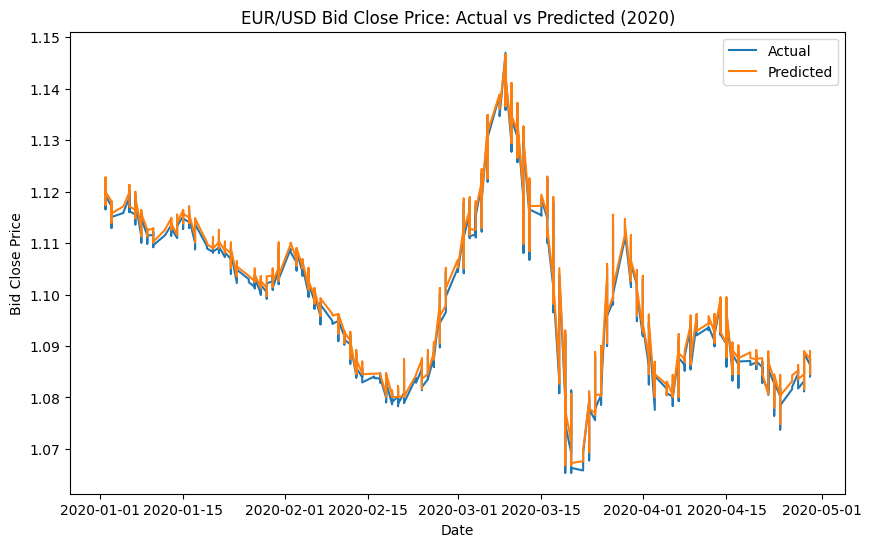

In [ ]:
import matplotlib.pyplot as plt

# Create the chart
plt.figure(figsize=(10, 6))
plt.plot(test['Date'], y_test, label='Actual')
plt.plot(test['Date'], y_pred, label='Predicted')
plt.title('EUR/USD Bid Close Price: Actual vs Predicted (2020)')
plt.xlabel('Date')
plt.ylabel('Bid Close Price')
plt.legend()
plt.show()

In [ ]:
model.save_model('lightgbm_eurusd_model.txt')

***Bayesian Boosting***

In [ ]:
pip install pandas numpy lightgbm catboost xgboost scikit-learn scikit-optimize matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 9.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from skopt import BayesSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

**Bayesian Optimization Setup**

In [ ]:
def evaluate_model(model, model_name, X_train, y_train, X_test, y_test, test_dates):
    # Fit model
    model.fit(X_train, y_train)
    # Predict
    y_pred = model.predict(X_test)
    # Metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    print(f'{model_name} - RMSE: {rmse:.4f}, MAE: {mae:.4f}')
    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(test_dates, y_test, label='Actual')
    plt.plot(test_dates, y_pred, label='Predicted')
    plt.title(f'{model_name}: EUR/USD Bid Close Price (2020)')
    plt.xlabel('Date')
    plt.ylabel('Bid Close Price')
    plt.legend()
    plt.show()
    return model

LightGBM with Bayesian Optimization

In [ ]:
import lightgbm as lgb

# Define parameter search space
lgb_param_space = {
    'num_leaves': (10, 100),
    'learning_rate': (0.01, 0.3, 'log-uniform'),
    'feature_fraction': (0.5, 1.0),
    'bagging_fraction': (0.5, 1.0),
    'bagging_freq': (1, 10)
}



In [ ]:
# Initialize LightGBM
lgb_model = lgb.LGBMRegressor(objective='regression', metric='rmse', verbose=-1)


In [ ]:
# Bayesian optimization
lgb_bayes = BayesSearchCV(
    lgb_model,
    lgb_param_space,
    n_iter=20,  # Number of trials
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

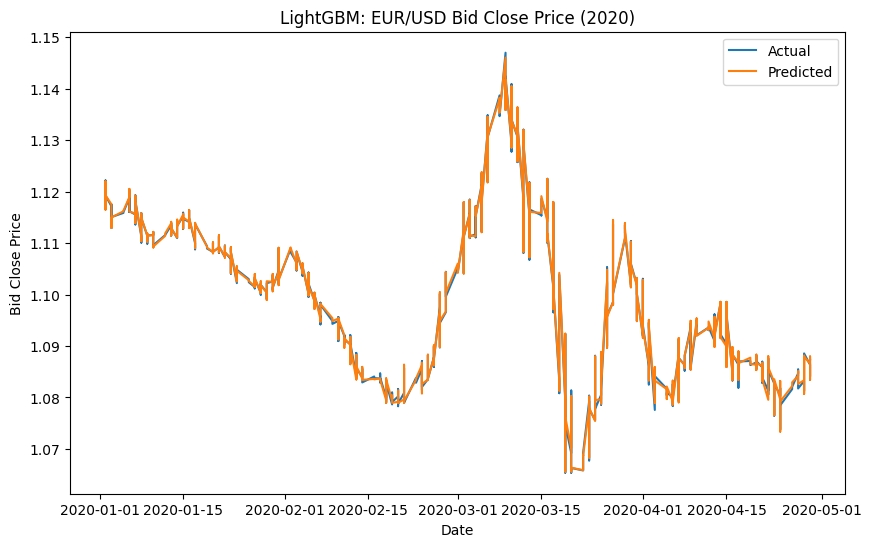

Best LightGBM Params: OrderedDict([('bagging_fraction', 0.5070070870477948), ('bagging_freq', 2), ('feature_fraction', 0.5), ('learning_rate', 0.07592023498342405), ('num_leaves', 100)])


In [ ]:

# Evaluate
lgb_bayes = evaluate_model(lgb_bayes, 'LightGBM', X_train, y_train, X_test, y_test, test['Date'])
print(f'Best LightGBM Params: {lgb_bayes.best_params_}')

CatBoost with Bayesian Optimization

In [ ]:
from catboost import CatBoostRegressor

# Define parameter search space
cat_param_space = {
    'depth': (4, 10),
    'learning_rate': (0.01, 0.3, 'log-uniform'),
    'l2_leaf_reg': (1, 10),
    'iterations': (100, 500)
}


In [ ]:

# Initialize CatBoost
cat_model = CatBoostRegressor(verbose=0)


In [ ]:

# Bayesian optimization
cat_bayes = BayesSearchCV(
    cat_model,
    cat_param_space,
    n_iter=20,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

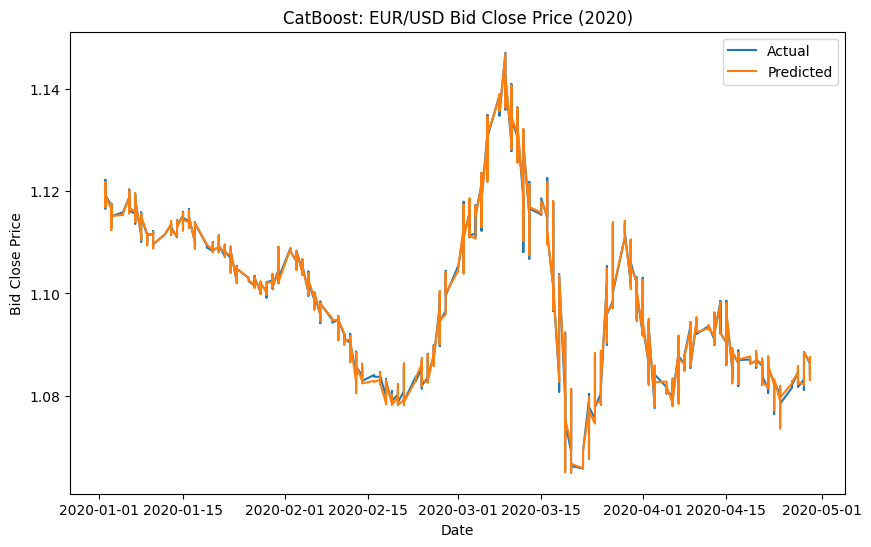

Best CatBoost Params: OrderedDict([('depth', 8), ('iterations', 439), ('l2_leaf_reg', 1), ('learning_rate', 0.1743842900147291)])


In [ ]:

# Evaluate
cat_bayes = evaluate_model(cat_bayes, 'CatBoost', X_train, y_train, X_test, y_test, test['Date'])
print(f'Best CatBoost Params: {cat_bayes.best_params_}')

XGBoost with Bayesian Optimization

In [ ]:
import xgboost as xgb

# Define parameter search space
xgb_param_space = {
    'max_depth': (3, 10),
    'learning_rate': (0.01, 0.3, 'log-uniform'),
    'subsample': (0.5, 1.0),
    'colsample_bytree': (0.5, 1.0),
    'n_estimators': (100, 500)
}


In [ ]:

# Initialize XGBoost
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')



In [ ]:
# Bayesian optimization
xgb_bayes = BayesSearchCV(
    xgb_model,
    xgb_param_space,
    n_iter=20,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)



Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

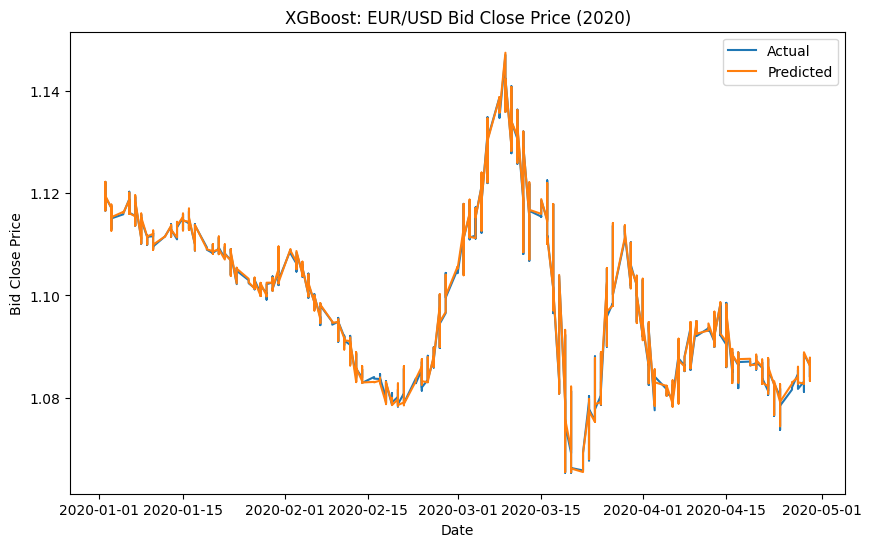

Best XGBoost Params: OrderedDict([('colsample_bytree', 0.7109122144801283), ('learning_rate', 0.07000666190303054), ('max_depth', 9), ('n_estimators', 100), ('subsample', 0.8488695000308639)])


In [ ]:
# Evaluate
xgb_bayes = evaluate_model(xgb_bayes, 'XGBoost', X_train, y_train, X_test, y_test, test['Date'])
print(f'Best XGBoost Params: {xgb_bayes.best_params_}')